In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import warnings
warnings.filterwarnings('ignore')

/kaggle/input/electricity-price-prediction/electricity.csv


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, LayerNormalization, Bidirectional, Attention
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.regularizers import l2
from keras.losses import Huber
from keras.optimizers import Adam
from keras.layers import Layer
import keras.backend as K
from keras import initializers
from keras.metrics import RootMeanSquaredError
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns
from scipy.stats import ttest_ind

## Data preprocessing

In [3]:
df = pd.read_csv('/kaggle/input/electricity-price-prediction/electricity.csv')
print(f"Data shape: {df.shape}")
df.head()

Data shape: (38014, 18)


,DateTime,Holiday,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay,ForecastWindProduction,SystemLoadEA,SMPEA,ORKTemperature,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,SMPEP2
0,01/11/2011 00:00,NaN,0,1,44,1,11,2011,0,315.31,3388.77,49.26,6.00,9.30,600.71,356.00,3159.60,54.32
1,01/11/2011 00:30,NaN,0,1,44,1,11,2011,1,321.80,3196.66,49.26,6.00,11.10,605.42,317.00,2973.01,54.23
2,01/11/2011 01:00,NaN,0,1,44,1,11,2011,2,328.57,3060.71,49.10,5.00,11.10,589.97,311.00,2834.00,54.23
3,01/11/2011 01:30,NaN,0,1,44,1,11,2011,3,335.60,2945.56,48.04,6.00,9.30,585.94,313.00,2725.99,53.47
4,01/11/2011 02:00,NaN,0,1,44,1,11,2011,4,342.90,2849.34,33.75,6.00,11.10,571.52,346.00,2655.64,39.87


In [4]:
print(df.columns.tolist())

['DateTime', 'Holiday', 'HolidayFlag', 'DayOfWeek', 'WeekOfYear', 'Day', 'Month', 'Year', 'PeriodOfDay', 'ForecastWindProduction', 'SystemLoadEA', 'SMPEA', 'ORKTemperature', 'ORKWindspeed', 'CO2Intensity', 'ActualWindProduction', 'SystemLoadEP2', 'SMPEP2']


In [24]:
cols_to_convert = df.columns[9:]  
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df['DateTime'] = pd.to_datetime(df['DateTime'], dayfirst = True)
df = df.sort_values('DateTime')
df.dropna(subset=['SMPEA'], inplace=True)

In [25]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 38012 entries, 0 to 38013
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DateTime                38012 non-null  datetime64[ns]
 1   Holiday                 1534 non-null   object        
 2   HolidayFlag             38012 non-null  int64         
 3   DayOfWeek               38012 non-null  int64         
 4   WeekOfYear              38012 non-null  int64         
 5   Day                     38012 non-null  int64         
 6   Month                   38012 non-null  int64         
 7   Year                    38012 non-null  int64         
 8   PeriodOfDay             38012 non-null  int64         
 9   ForecastWindProduction  38009 non-null  float64       
 10  SystemLoadEA            38012 non-null  float64       
 11  SMPEA                   38012 non-null  float64       
 12  ORKTemperature          37719 non-null  float64    

,DateTime,HolidayFlag,DayOfWeek,WeekOfYear,Day,Month,Year,PeriodOfDay,ForecastWindProduction,SystemLoadEA,SMPEA,ORKTemperature,ORKWindspeed,CO2Intensity,ActualWindProduction,SystemLoadEP2,SMPEP2
count,38012,38012.000000,38012.000000,38012.000000,38012.000000,38012.000000,38012.000000,38012.000000,38009.000000,38012.000000,38012.000000,37719.000000,37715.000000,38007.000000,38009.000000,38012.000000,38012.000000
mean,2012-11-30 23:54:54.948963328,0.040356,2.997159,28.125381,15.738609,6.904451,2012.383826,23.502210,544.261451,4020.085019,62.720388,9.626369,19.211770,479.373040,520.762819,3785.973841,64.136823
min,2011-11-01 00:00:00,0.000000,0.000000,1.000000,1.000000,1.000000,2011.000000,0.000000,0.680000,2183.940000,0.000000,-4.000000,0.000000,0.000000,1.000000,1809.960000,-47.740000
25%,2012-05-17 00:22:30,0.000000,1.000000,15.000000,8.000000,4.000000,2012.000000,12.000000,189.670000,3281.207500,45.530000,6.000000,13.000000,421.105000,199.000000,3058.277500,45.780000
50%,2012-11-30 23:45:00,0.000000,3.000000,29.000000,16.000000,7.000000,2012.000000,24.000000,441.980000,4103.600000,55.230000,9.000000,18.500000,480.310000,445.000000,3865.745000,55.545000
75%,2013-06-17 00:07:30,0.000000,5.000000,43.000000,23.000000,10.000000,2013.000000,36.000000,839.460000,4638.532500,70.320000,13.000000,24.100000,537.520000,793.000000,4427.590000,72.110000
max,2013-12-31 23:30:00,1.000000,6.000000,52.000000,31.000000,12.000000,2013.000000,47.000000,1680.000000,6492.910000,587.580000,25.000000,75.900000,842.880000,1769.000000,6309.750000,1000.000000
std,NaN,0.196795,1.999893,15.587599,8.803782,3.573677,0.624956,13.852634,414.364629,860.476866,32.252334,4.439934,9.571311,85.354706,378.282975,843.269455,35.415036


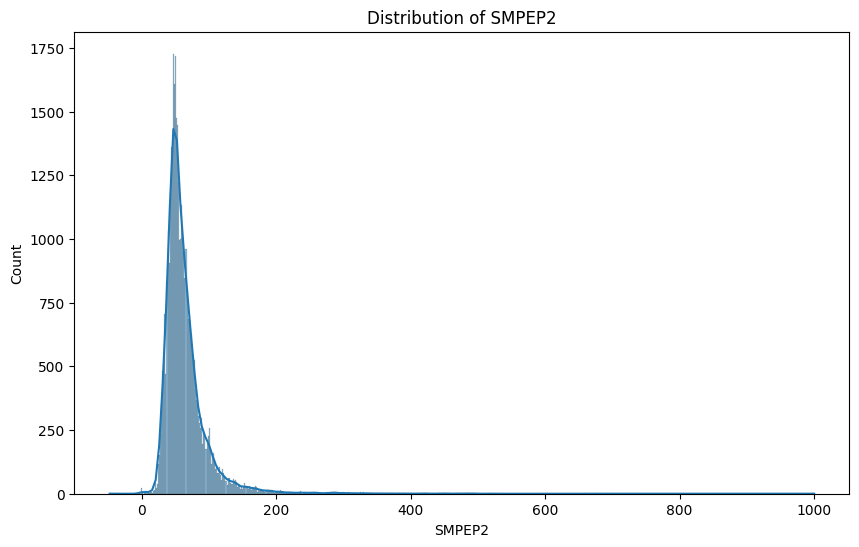

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(df['SMPEP2'], kde=True)
plt.title("Distribution of SMPEP2")
plt.show()

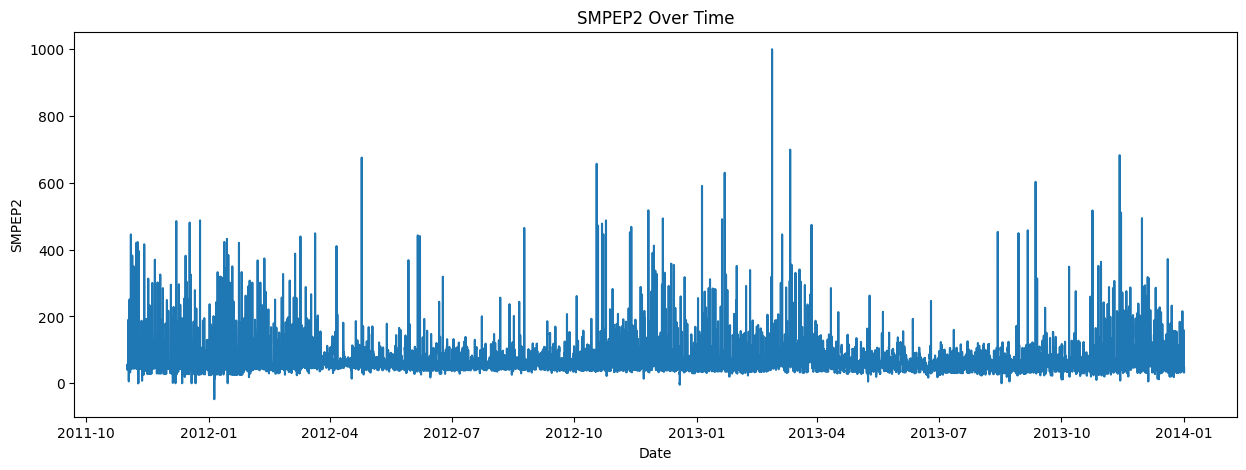

In [28]:
plt.figure(figsize=(15, 5))
plt.plot(df['DateTime'], df['SMPEP2'])
plt.title("SMPEP2 Over Time")
plt.xlabel("Date")
plt.ylabel("SMPEP2")
plt.show()

In [29]:
lower = df['SMPEP2'].quantile(0.01)
upper = df['SMPEP2'].quantile(0.99)
df['SMPEP2'] = df['SMPEP2'].clip(lower, upper)

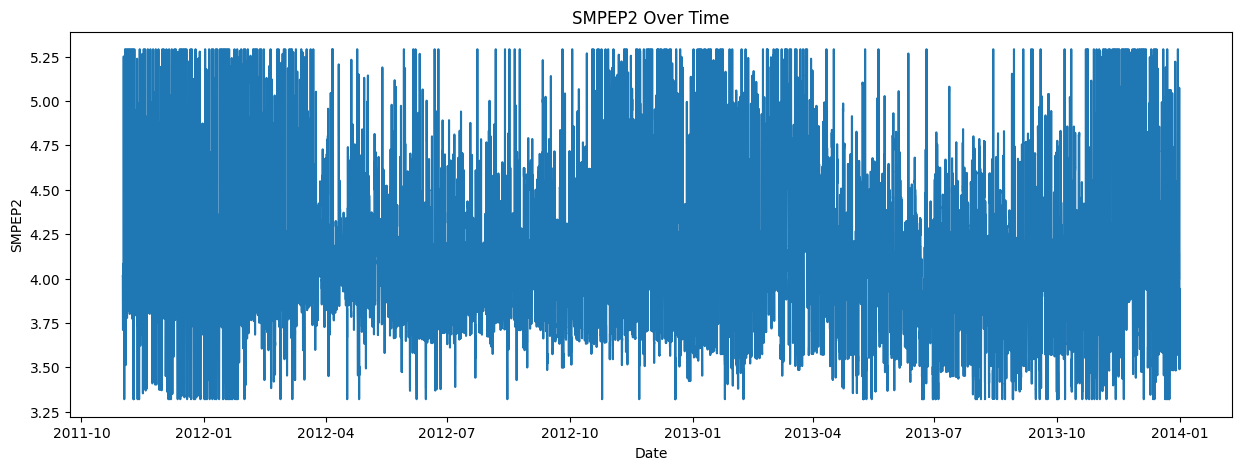

In [30]:
df['SMPEP2_log'] = np.log1p(df['SMPEP2'])
plt.figure(figsize=(15, 5))
plt.plot(df['DateTime'], df['SMPEP2_log'])
plt.title("SMPEP2 Over Time")
plt.xlabel("Date")
plt.ylabel("SMPEP2")
plt.show()

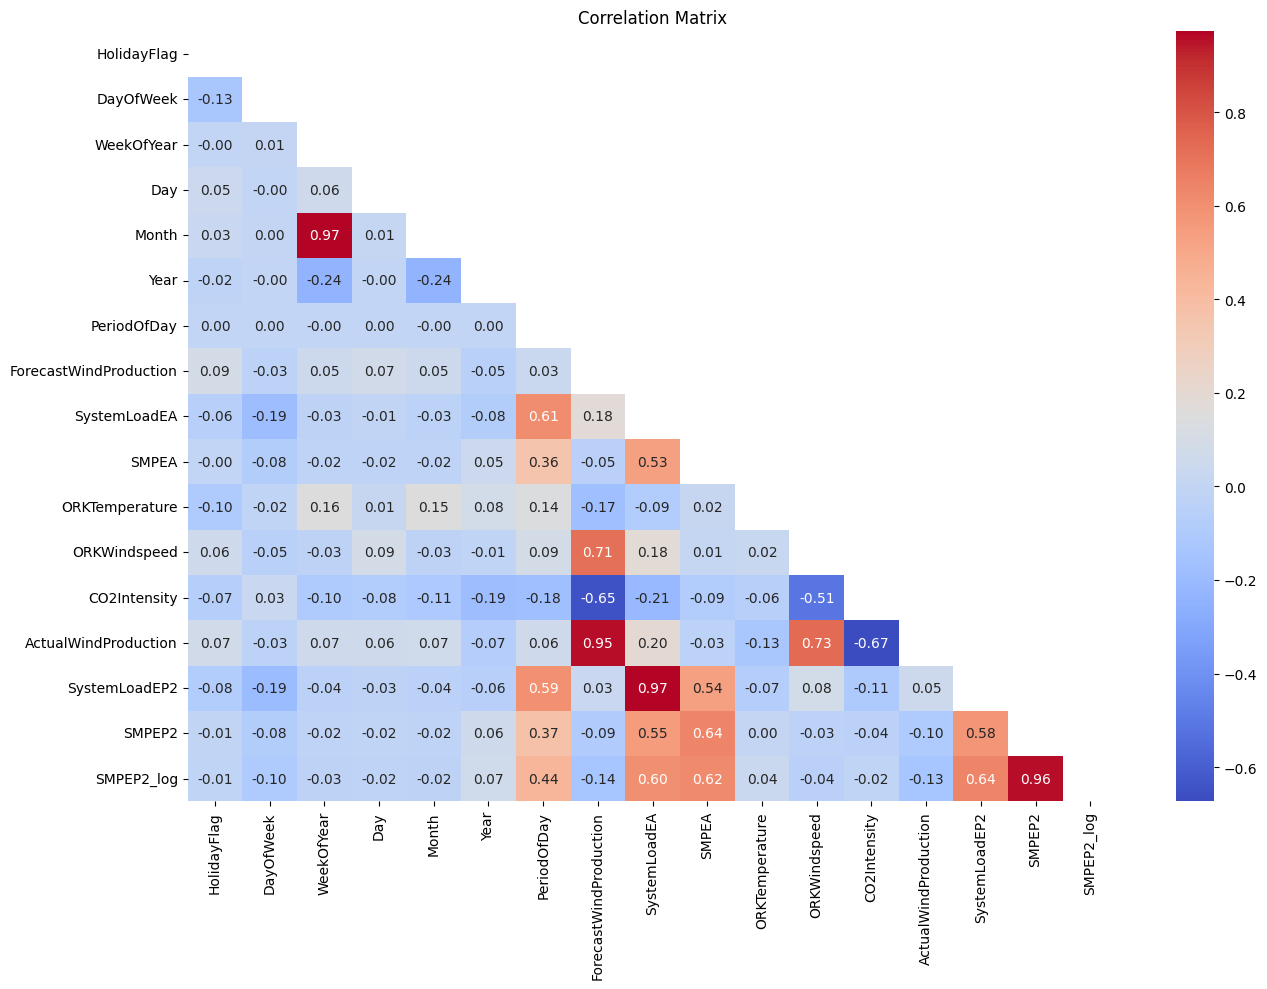

In [31]:
corr = df.select_dtypes(include=np.number).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", mask=np.triu(np.ones_like(corr, dtype=bool)))
plt.title("Correlation Matrix")
plt.show()

In [32]:
df.fillna(method='ffill', inplace=True)  

In [33]:
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek  
df['Month'] = df['DateTime'].dt.month

In [34]:
features = [
    'SMPEP2',         
    'SystemLoadEP2',   
    'SMPEA',
    'CO2Intensity',    
    'Hour',            
    'DayOfWeek'        
]

In [35]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)

In [36]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])  
        y.append(data[i+seq_length, 0])     
    return np.array(X), np.array(y)

seq_length = 48  
X, y = create_sequences(df_scaled.values, seq_length)

In [37]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [38]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

2025-05-24 10:10:52.065879: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [39]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/50
428/428 - 30s - 70ms/step - loss: 0.0185 - mae: 0.0839 - val_loss: 0.0044 - val_mae: 0.0417
Epoch 2/50
428/428 - 24s - 57ms/step - loss: 0.0105 - mae: 0.0571 - val_loss: 0.0032 - val_mae: 0.0326
Epoch 3/50
428/428 - 23s - 54ms/step - loss: 0.0090 - mae: 0.0507 - val_loss: 0.0029 - val_mae: 0.0297
Epoch 4/50
428/428 - 23s - 54ms/step - loss: 0.0085 - mae: 0.0481 - val_loss: 0.0030 - val_mae: 0.0313
Epoch 5/50
428/428 - 24s - 56ms/step - loss: 0.0081 - mae: 0.0462 - val_loss: 0.0029 - val_mae: 0.0311
Epoch 6/50
428/428 - 23s - 54ms/step - loss: 0.0079 - mae: 0.0454 - val_loss: 0.0027 - val_mae: 0.0280
Epoch 7/50
428/428 - 23s - 54ms/step - loss: 0.0079 - mae: 0.0449 - val_loss: 0.0027 - val_mae: 0.0288
Epoch 8/50
428/428 - 23s - 55ms/step - loss: 0.0076 - mae: 0.0439 - val_loss: 0.0030 - val_mae: 0.0336
Epoch 9/50
428/428 - 23s - 54ms/step - loss: 0.0075 - mae: 0.0437 - val_loss: 0.0030 - val_mae: 0.0323
Epoch 10/50
428/428 - 25s - 59ms/step - loss: 0.0074 - mae: 0.0434 - val_

In [40]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
MAE: 0.04, RMSE: 0.08


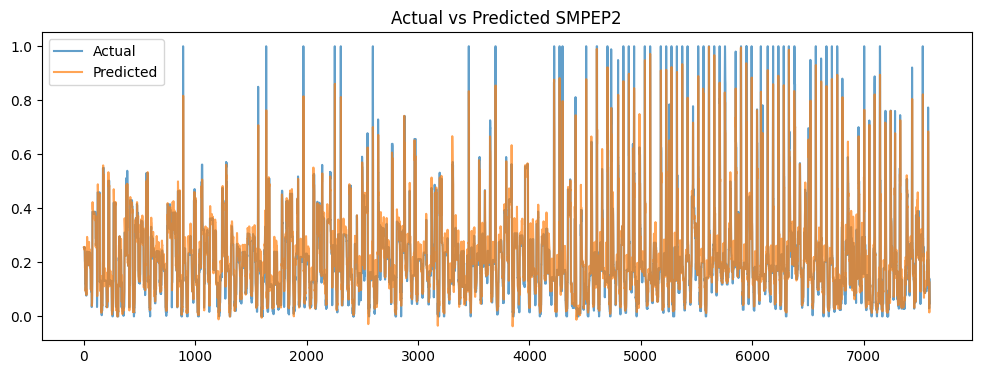

In [41]:
plt.figure(figsize=(12, 4))
plt.plot(y_test, label="Actual", alpha=0.7)
plt.plot(y_pred, label="Predicted", alpha=0.7)
plt.legend()
plt.title("Actual vs Predicted SMPEP2")
plt.show()

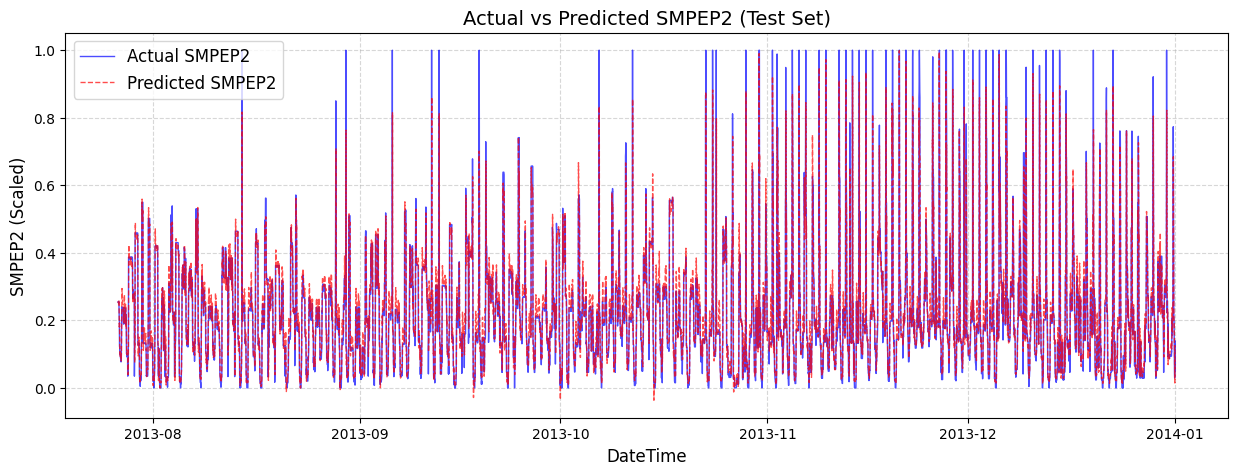

In [42]:
test_dates = df['DateTime'].iloc[-len(y_test):]  

plt.figure(figsize=(15, 5))
plt.plot(test_dates, y_test, label='Actual SMPEP2', color='blue', alpha=0.7, linewidth=1)
plt.plot(test_dates, y_pred, label='Predicted SMPEP2', color='red', alpha=0.7, linestyle='--', linewidth=1)
plt.title("Actual vs Predicted SMPEP2 (Test Set)", fontsize=14)
plt.xlabel("DateTime", fontsize=12)
plt.ylabel("SMPEP2 (Scaled)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [43]:
y_test_original = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), X_test[:, -1, :]], axis=1))[:, 0]
y_pred_original = scaler.inverse_transform(np.concatenate([y_pred.reshape(-1, 1), X_test[:, -1, :]], axis=1))[:, 0]

mae_original = mean_absolute_error(y_test_original, y_pred_original)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
print(f"MAE (Original Units): {mae_original:.2f}")
print(f"RMSE (Original Units): {rmse_original:.2f}")

MAE (Original Units): 6.49
RMSE (Original Units): 13.55


In [47]:
range_val = df['SMPEP2'].astype(float).max() - df['SMPEP2'].astype(float).min()
print("Range of SMPEP2:", range_val)

Range of SMPEP2: 170.91679999999934


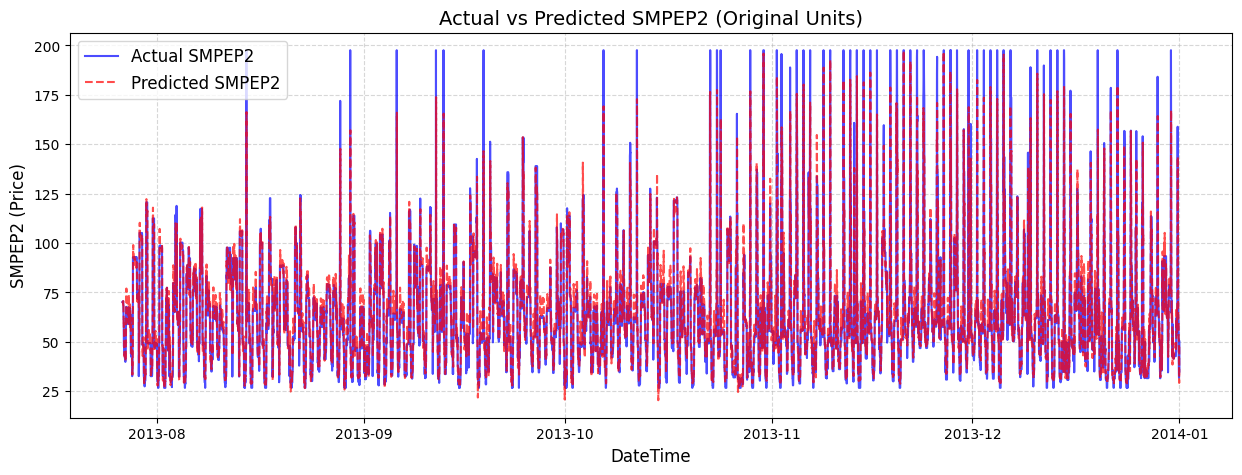

In [44]:
plt.figure(figsize=(15, 5))
plt.plot(test_dates, y_test_original, label='Actual SMPEP2', color='blue', alpha=0.7)
plt.plot(test_dates, y_pred_original, label='Predicted SMPEP2', color='red', alpha=0.7, linestyle='--')
plt.title("Actual vs Predicted SMPEP2 (Original Units)", fontsize=14)
plt.xlabel("DateTime", fontsize=12)
plt.ylabel("SMPEP2 (Price)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

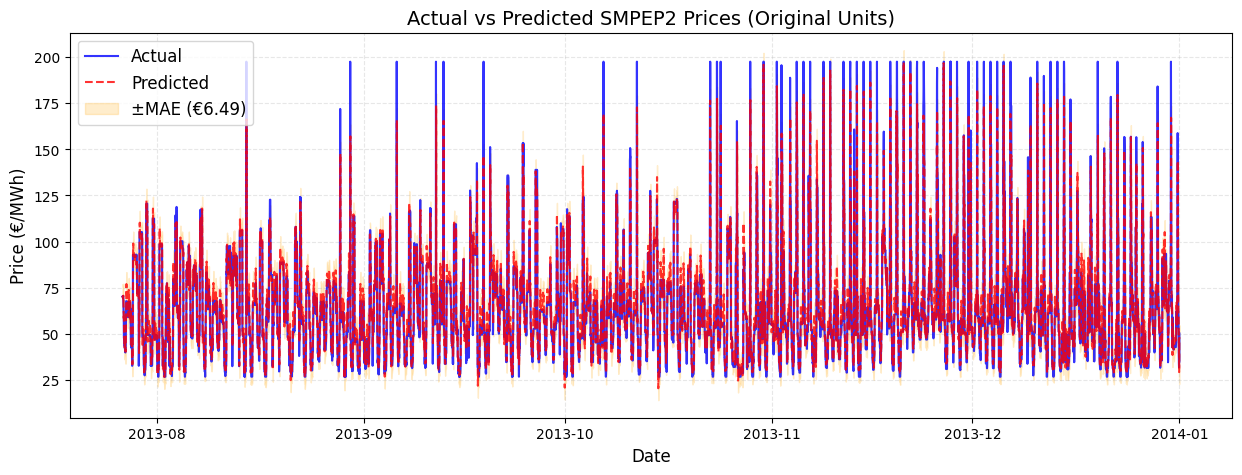

In [45]:
plt.figure(figsize=(15, 5))
plt.plot(test_dates, y_test_original, label='Actual', color='blue', linewidth=1.5, alpha=0.8)
plt.plot(test_dates, y_pred_original, label='Predicted', color='red', linestyle='--', linewidth=1.5, alpha=0.8)
plt.fill_between(test_dates, y_pred_original - mae_original, y_pred_original + mae_original, 
                color='orange', alpha=0.2, label='±MAE (€6.49)')
plt.title("Actual vs Predicted SMPEP2 Prices (Original Units)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (€/MWh)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

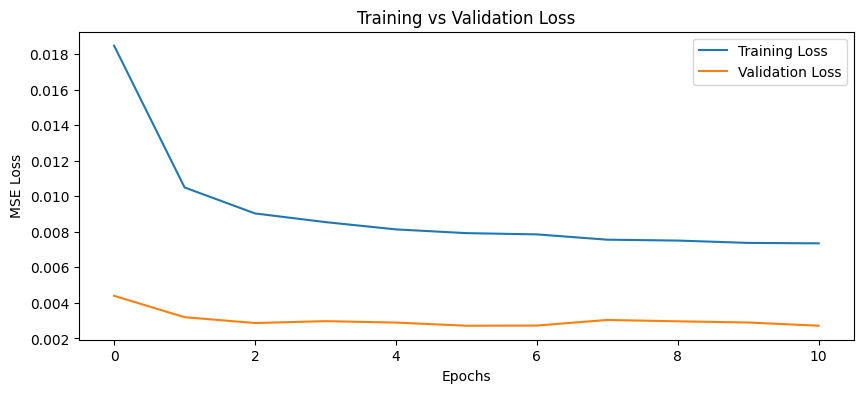

In [46]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# Some improvements

In [48]:
df['SMPEP2'] = df['SMPEP2'].clip(df['SMPEP2'].quantile(0.01), df['SMPEP2'].quantile(0.99))
def cyclic_encode(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df

df = cyclic_encode(df, 'Hour', 24)      
df = cyclic_encode(df, 'DayOfWeek', 7)
df = cyclic_encode(df, 'Month', 12)  

In [49]:
df['SMPEP2_lag24'] = df['SMPEP2'].shift(48)  

df['SMPEP2_rolling_avg_6h'] = df['SMPEP2'].rolling(12).mean() 
df['SMPEP2_rolling_std_6h'] = df['SMPEP2'].rolling(12).std()

In [50]:
features = [
    'SystemLoadEP2', 'SMPEA', 'CO2Intensity', 'ActualWindProduction',
    'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos',
    'SMPEP2_lag24', 'SMPEP2_rolling_avg_6h'
]
target = 'SMPEP2'

df_clean = df[features + [target]].dropna()
X = df_clean[features]
y = df_clean[target]

In [51]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 48 
X_seq, y_seq = create_sequences(X_scaled, y.values, seq_length)

In [52]:
train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

In [54]:
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(seq_length, X_train.shape[2]))),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae']
)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 83s 186ms/step - loss: 2166.6968 - mae: 34.5749 - val_loss: 676.6047 - val_mae: 18.7895
Epoch 2/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 65s 171ms/step - loss: 866.1688 - mae: 19.9831 - val_loss: 662.5397 - val_mae: 18.4940
Epoch 3/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 69s 182ms/step - loss: 716.4048 - mae: 17.1332 - val_loss: 449.0647 - val_mae: 15.2218
Epoch 4/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 63s 166ms/step - loss: 497.9524 - mae: 14.2864 - val_loss: 390.1008 - val_mae: 13.6264
Epoch 5/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 63s 166ms/step - loss: 443.5268 - mae: 13.3924 - val_loss: 337.4884 - val_mae: 12.4147
Epoch 6/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 66s 175ms/step - loss: 379.0656 - mae: 12.5237 - val_loss: 309.0080 - val_mae: 12.7241
Epoch 7/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 64s 167ms/step - loss: 355.1755 - mae: 11.9834 - val_loss: 287.1035 - val_mae: 11.3388
Epoch 8/100
380/380 ━━━━━━━━━━━━━━━━━━━━ 64s 169ms/step - loss: 352.8753 - mae: 11.6467 - val_loss: 269

In [55]:
y_pred = model.predict(X_test)
y_test_original = y_test
y_pred_original = y_pred.flatten()

mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

237/237 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step
MAE: 9.81, RMSE: 15.49


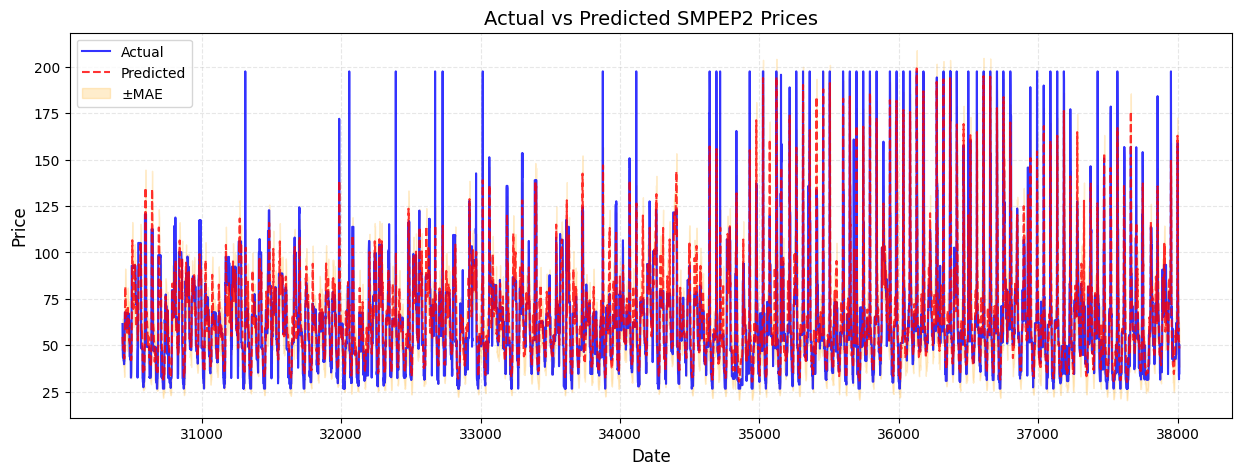

In [57]:
test_dates = df_clean.index[-len(y_test):]

plt.figure(figsize=(15, 5))
plt.plot(test_dates, y_test_original, label='Actual', color='blue', alpha=0.8)
plt.plot(test_dates, y_pred_original, label='Predicted', color='red', linestyle='--', alpha=0.8)
plt.fill_between(test_dates, 
                y_pred_original - mae, 
                y_pred_original + mae, 
                color='orange', alpha=0.2, label='±MAE')
plt.title("Actual vs Predicted SMPEP2 Prices", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()